<center>
    <img src="https://github.com/TUIlmenauAMS/MLfAS_Tutorials/blob/main/images/mlfasp.png?raw=1">
</center>

#### Prof. Dr. -Ing. Gerald Schuller <br> Jupyter Notebook: Renato Profeta

[Applied Media Systems Group](https://www.tu-ilmenau.de/en/applied-media-systems-group/) <br>
[Technische Universität Ilmenau](https://www.tu-ilmenau.de/)

# Neural Network as Function Approximator, Regression

In [ ]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/eg6nZJz05eA?rel=0" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

We can use a neural network to approximate a function:
$$\large
y=f(x)$$

In our simple example *x* is a (1-dimensional) sample, and *y* is the (also 1-dimensional) target (also called regression).

This function could be, for instance, an audio signal like a tone, which would be a sinusoidal function. Here, *x* would be the time dimension, and *y* would a sample from or to the sound card.

In Pytorch we have a `torch.sin()` function, which directly produces a torch tensor, and also a `torch.randn()` function, which produces random numbers according to a gaussian distribution with zero mean and unit variance. We can use this to simulate microphone and pickup noise.

We generate our target function in the beginning with:






In [ ]:
# -*- coding: utf-8 -*-
__author__ = 'Gerald Schuller'
__copyright__ = 'G.S.'

"""
Simple program to use a fully connected linear neural network layer as a 1-dimensional faunction y=f(x) approximator.
This could be for instance an audio signal, x would be the time, y would be the audio signal value.
Gerald Schuller, Dec. 2019.
---------------------------------------------------------------------------------------------
Ported to Jupyter Notebook by Renato Profeta, August, 2020
"""

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

device='cpu'
#device='cuda'

N=40 #number of samples in our signal
print("Number of input samples:", N)
#input tensor, type torch tensor:
#Indices: batch, additional dimensions, features or signal dimension. Here: 1 batch, 3 samples, signal dimension 2:
#Training set:
#The x input here is the time:
X=torch.arange(0,N,1.0) #generates N time steps for X
X=X.view(N,1) #adding the last dimension for the signal (1 sample each), first dimension for the batch of size N
print("X.shape", X.shape)
#Target here is the (noisy) function value, a sine function + normal distributed random values:
#Y=torch.sin(X)+torch.empty(X.shape).normal_(std=0.5)
Y=torch.sin(X*3.14/N*2)+torch.randn(X.shape)*0.1
#2 periods of the sinusoid in our training set, plus noise
print("Y.shape", Y.shape)

Number of input samples: 40
X.shape torch.Size([40, 1])
Y.shape torch.Size([40, 1])


Often we want our network to interpolate the function between the training samples, and also to extrapolate beyond the training samples. Hence we construct a validation set which has the *X* samples between the integer values of the training set, and extend it to beyond the length of the training set. To see how robust our network is against the noise in the training set, we also add new noise.


In [ ]:
Xval=torch.arange(0.5,2*N,1.0) #generates 2N time steps for X for extrapolation beyond N,
#shifted by 0.5 compared to training set,
#for interpolation between the original sample points.
#print("Xval=", Xval)
Xval=Xval.view(2*N,1)
#Validation Target:
Yval=torch.sin(Xval*3.14/N*2)+torch.randn(Xval.shape)*0.1
print("generated validation set, to test generalization, with new noise")

generated validation set, to test generalization, with new noise


Now we have to decide what kind of network to use. We try to find one which is as simple as possible for the task. We choose a structure which is in principle able to approximate the function piece-wise. We use a number of nodes in the network, and each node is in effect "responsible" for a piece of the function. We can do this with a 3-layer fully connected network with activation function (see also:
http://deeplearning.stanford.edu/tutorial/supervised/MultiLayerNeuralNetworks )

The first layer is the **input layer**, which takes 1 input sample of *X*, then distributes this sample to N **"hidden" nodes**, with weights, each node then has a bias which basically "activates" it for certain value ranges of *X*, and the activation function, for instance the Sigmoid function, which is mainly "active" in the input range of -4 to 4, followed by weights to the **output layer**, which in our case is simply one node which sums up all the inputs from the hidden nodes, with weights but with no activation function.

This can be seen in the following picture:
<figure>
<img src='https://github.com/TUIlmenauAMS/MLfAS_Tutorials/blob/main/images/02_01_neuralNetsAppro.png?raw=1' width='600'>
<figcaption>Figure: Our neural network for function approximation.</figcaption>
</figure>

We define our 3-layer neural network with the following class in Pytorch:



In [ ]:
Nodes=10 #Number of Nodes in the hidden layer. This results in a smooth interpolation
#Nodes=80  #this can result in over-fitting
print("number of nodes:", Nodes)

#A 2-layer fully connected network, 1 input (time value), hidden layer has "Nodes" nodes, 1 output (function value).

class LinNet(nn.Module):
    #define and initialize the layers:
    def __init__(self):
        super(LinNet, self).__init__()
        # Define the model.
        #https://pytorch.org/docs/stable/nn.html?highlight=linear#torch.nn.Linear
        # Generate a fully connected linear neural network model, 2 layers, bias
        # returns: Trainable object
        self.layer1=nn.Sequential(nn.Linear(in_features=1, out_features=Nodes, bias=True))
        self.layer2=nn.Sequential(nn.Linear(in_features=Nodes, out_features=1, bias=True))

        #self.act = nn.LeakyReLU() #non-linear activation function
        #self.act = nn.ReLU() #non-linear activation function
        #self.act = nn.Hardtanh() #non-linear activation function
        self.act = nn.Sigmoid() #non-linear activation function

    #Putting the network together:
    def forward(self, x):
        out = self.layer1(x)
        #print("out.shape=", out.shape)
        out = self.act(out)  #comment out if not desired
        #print("out.shape=", out.shape)
        out = self.layer2(out)
        #print("out.shape=", out.shape)
        return out

number of nodes: 10


Then in the following main section, we instantiate and initialize the model, which is initialized with random weight values. Part of the printouts are the initial weights before the optimization. They are printed on line 7.

Observe the hopefully decreasing loss values, printed after the "epoch's", during training.




In [ ]:
#create network object:
model = LinNet().to(device)
#Before training:
Ypred=model(X) #the model produces prediction output
print("Ypred.shape=", Ypred.shape)
weights = model.state_dict()   #read obtained weights
print("initial weights=", weights)  #see the random initialization of the weights

#print("model.parameters()=", model.parameters())

print("Define loss function:")
loss_fn = nn.MSELoss() #mean squared error loss

print("Define optimizer:")
#learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters())
#optimizer = torch.optim.SGD(model.parameters(),lr=0.1)
print("Optimizing:")
for epoch in range(10000):
    Ypred=model(X) #the model produces prediction output
    loss=loss_fn(Ypred, Y) #prediction and target compared by loss
    if epoch%1000==0:
        print(epoch, loss.item()) #print current loss value
    optimizer.zero_grad() #optimizer sets previous gradients to zero
    loss.backward() #optimizer computes new gradients
    optimizer.step() #optimizer updates weights

Ypred.shape= torch.Size([40, 1])
initial weights= OrderedDict([('layer1.0.weight', tensor([[ 0.9107],
        [ 0.1554],
        [-0.8755],
        [-0.0897],
        [-0.5889],
        [-0.2176],
        [-0.5943],
        [-0.2721],
        [-0.1724],
        [-0.0458]])), ('layer1.0.bias', tensor([-0.0930,  0.1999,  0.0314,  0.2774, -0.3861,  0.2089, -0.8518,  0.2971,
         0.4344,  0.6348])), ('layer2.0.weight', tensor([[ 0.2106,  0.2835, -0.0212, -0.0984, -0.2484,  0.0731, -0.3152,  0.1535,
          0.2769, -0.2790]])), ('layer2.0.bias', tensor([-0.1164]))])
Define loss function:
Define optimizer:
Optimizing:
0 0.6036805510520935
1000 0.07570836693048477
2000 0.05626023933291435
3000 0.050487495958805084
4000 0.04613465815782547
5000 0.04212510958313942
6000 0.03859785199165344
7000 0.03596413880586624
8000 0.03427383303642273
9000 0.02575293555855751


Now we can compute the resulting loss value on the training set and validation set, and plot the obtained learned function in comparison to the (noisy) target function for training and validation.

For plotting and printing we need numpy arrays, hence we need to convert from pytorch tensors to numpy arrays, which we do with the function `.detach().numpy()`.


In [ ]:
Ypred=model(X) # Make Predictions based on the obtained weights
#print("Ypred training set=", Ypred)
loss=loss_fn(Ypred, Y)
print("Loss on trainig set:", loss.detach().numpy())

Yvalpred=model(Xval) # Make Predictions based on the obtained weights
#print("Y validation set=", Yvalpred.detach().numpy())
loss=loss_fn(Yvalpred[:N,:], Yval[:N,:])
print("Loss on validation set:", loss.detach().numpy())

Loss on trainig set: 0.014503452
Loss on validation set: 0.019217055


In [ ]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/idU5m3sNI28?rel=0" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

Observe the data format of the initial weights above. Its first dictionary entry is `layer1.0.weight`, which is a 2-dimensional tensor or matrix.
This represents the matrix 'A' of the first linear layer of our network. Look at the master documentation of pytorch at:

In [ ]:
%%html
<iframe src="https://pytorch.org/docs/stable/nn.html#linear-layers" width="900" height="600"></iframe>

Remember that its equation was:

$$\large
y=x \cdot A^T + b $$

In our case  "*x*"  consists of just 1 feature (it is 1- dimensional), and we have *N* output features (or nodes).
Compare with the network picture in the first part. Hence "A" must have 1 column of N entries, which is what we observe.

After that we see `layer1.0.bias`, which is the bias vector with *N* entries, one bias entry for each output node.

Then we have `layer2.0.weight`, which are the weights for the next layer, which has N input features and one output feature (the approximated function value). Hence it has one row with N elements.

Finally we have the bias for this layer. It has only one entry, since it only contains one node.

Then the optimization runs, and we obtain the losses.

So the loss on the validation set is somewhat higher than for the training, but less than a factor of 2, which is not too bad.

If we increase the number of nodes to 80 or 100, we will observe that the loss on the training set will go down, but the loss on the validation set goes up, which is a sign of **overfitting**.

Also try the activation function **"LeakyReLu"** for this case of 80 Nodes. It leads to a similar loss. Now try **"ReLu"**, and  you will find that the optimizer has a much harder time to find a good solution, because of the **vanishing gradient** of the ReLu activation function for negative inputs.

The function plot for the 10 Node training set is:

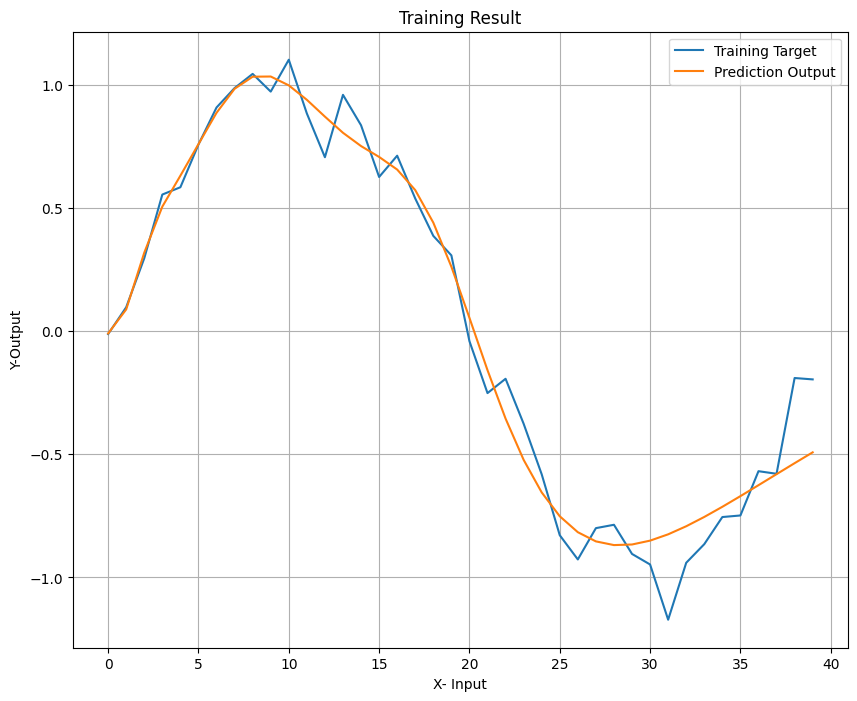

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(X.detach().numpy()[:,0],Y.detach().numpy()[:,0])
plt.plot(X.detach().numpy()[:,0],Ypred.detach().numpy()[:,0])
plt.legend(('Training Target', 'Prediction Output'))
plt.xlabel('X- Input')
plt.ylabel('Y-Output')
plt.title('Training Result')
plt.grid()

We see that we get indeed a smoothed version of the training set, which means our network is somewhat robust against the noise on the training set.

The plot for the validation set is:

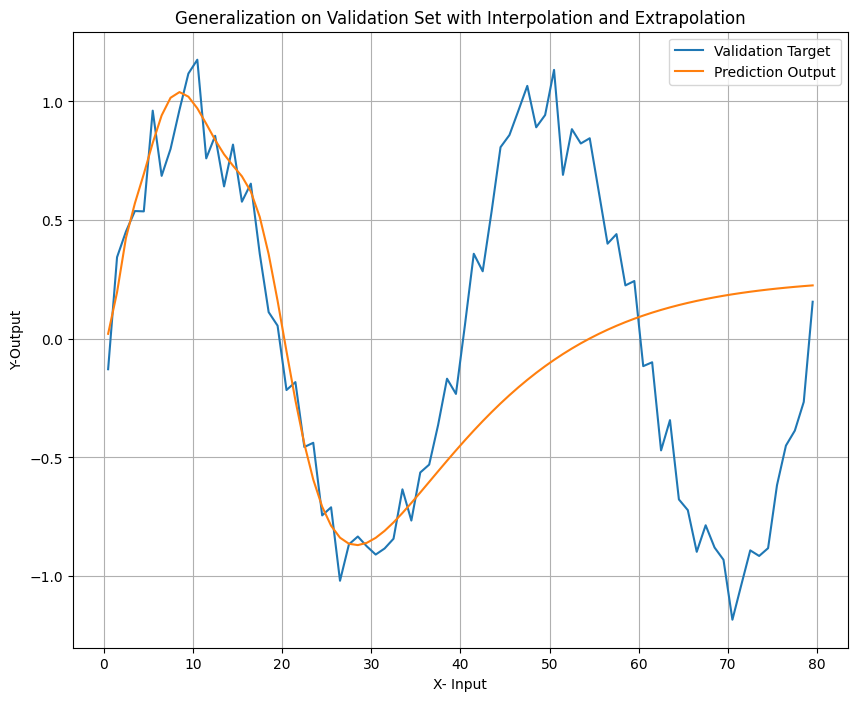

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(Xval.detach().numpy()[:,0],Yval.detach().numpy()[:,0])
plt.plot(Xval.detach().numpy()[:,0],Yvalpred.detach().numpy()[:,0])
plt.xlabel('X- Input')
plt.ylabel('Y-Output')
plt.title('Generalization on Validation Set with Interpolation and Extrapolation')
plt.legend(('Validation Target', 'Prediction Output'))
plt.grid()

We see that we have a good interpolation on the X range of the training set, but the extrapolation beyond this training range is not really working.

The resulting function from the network is the sum of the functions of the N nodes.

To see the functions of the individual nodes, we can just keep their weight unchanged, set the others to zero, and plot the resulting function. For that we make mask with zeros for the weights of layer 2, except for one node, and plot the function. Then we repeat this for every node in a "for" loop,

weights= OrderedDict([('layer1.0.weight', tensor([[ 0.4836],
        [ 0.0853],
        [-0.4843],
        [ 0.3269],
        [-0.5921],
        [-0.3326],
        [-1.6728],
        [-0.3077],
        [-0.2898],
        [ 0.3357]])), ('layer1.0.bias', tensor([-5.3481, -2.4502,  7.5526, -6.2010,  3.1119,  5.3025,  2.7001,  4.5243,
         3.6866, -0.6242])), ('layer2.0.weight', tensor([[ 0.7506,  2.5743, -3.5592, -2.4975, -1.4832,  1.9697, -0.5753,  1.8536,
          1.6356, -0.7430]])), ('layer2.0.bias', tensor([0.1740]))])
model.state_dict()['layer2.0.weight']= tensor([[ 0.7506,  2.5743, -3.5592, -2.4975, -1.4832,  1.9697, -0.5753,  1.8536,
          1.6356, -0.7430]])


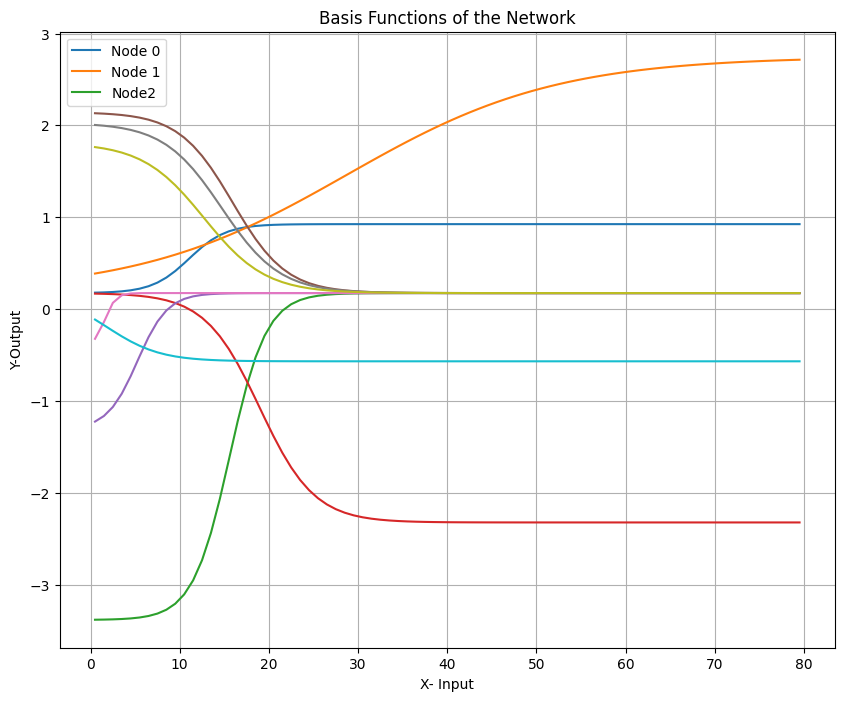

In [ ]:
weights = model.state_dict()   #read obtained weights
print("weights=", weights)
#Weights of layer 2:
layer2weights=model.state_dict()['layer2.0.weight'].clone() #clone(), otherwise it is just a pointer!
print("model.state_dict()['layer2.0.weight']=", layer2weights)

#The resulting function from the network is the sum of the functions of the N nodes.
#To see the functions of the individual nodes, we can just keep their weight unchanged,
#set the others to zero, and plot the resulting function.
#For that we make mask with zeros for the weights of layer 2, except for one node:

plt.figure(figsize=(10,8))
plt.xlabel('X- Input')
plt.ylabel('Y-Output')
plt.title('Basis Functions of the Network')

for node in range(0,Nodes):
    weightmask=torch.zeros(layer2weights.shape) #mask with all zeros for output layer, except one.
    weightmask[0,node]=1.0 #node "node" unchanged
    #print("weightmask",weightmask)
    #print("layer2weights=",layer2weights)
    #print("layer2weights*weightmask=", layer2weights*weightmask)
    model.state_dict()['layer2.0.weight'].data.copy_(layer2weights*weightmask) #write pytorch structure back to model
    #print("Xval=", Xval)
    Ypred1node=model(Xval) # Make Predictions based on the 1-node weights
    #print("Ypred1node=", Ypred1node)
    #Plot modified 1-node model:
    plt.plot(Xval.detach().numpy()[:,0],Ypred1node.detach().numpy()[:,0])
plt.grid()
plt.legend(('Node 0', 'Node 1', 'Node2'));
 #We see the activation function fit with bias and weight
#to different parts of the target function


We see the activation function of each node is fit with bias and weight to different parts of the target function. Since the activation function is only fitted over the training range, they all become flat after that, and hence their sum also becomes constant.

## Deep Function Approximator

In [ ]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/iqFrQbKNdO4?rel=0" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

Instead of having a relatively flat network with only 3 layers, we can now distribute or nodes over more layers, each containing fewer nodes. In this way we obtain a more narrow and deeper network.

In the example we have 5 layers, or 4 linear layers, but each layer has only 2 nodes, so the total number of nodes is similar:

<img src='https://github.com/TUIlmenauAMS/MLfAS_Tutorials/blob/main/images/02_02_neuralNetsApproDeep.png?raw=1' width='800'>


In [ ]:
"""
Simple program to use a fully connected linear neural network layer as a 1-dimensional faunction y=f(x) approximator, using a deep network of several smaller layers instead of a wide layer.
This could be for instance an audio signal, x would be the time, y would be the audio signal value.
Gerald Schuller, Jan. 2020.
--------------------------------------------
Ported to Jupyter Notebook by Renato Profeta, Auguts 2020
"""

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

device='cpu'
#device='cuda'

N=40 #number of samples in our signal
Nodes=2 #Nodes in each layer
#Nodes=80  #this can result in over-fitting

#A multi-layer fully connected network, 1 input (time value), hidden layer has Nodes nodes, 1 output (function value).

class LinNet(nn.Module):
    #define and initialize the layers:
    def __init__(self):
        super(LinNet, self).__init__()
        # Define the model.
        #https://pytorch.org/docs/stable/nn.html?highlight=linear#torch.nn.Linear
        # Generate a fully connected linear neural network model, 2 layers, bias
        # returns: Trainable object
        self.layer1=nn.Sequential(nn.Linear(in_features=1, out_features=Nodes, bias=True))
        self.layer2=nn.Sequential(nn.Linear(in_features=Nodes, out_features=Nodes, bias=True))
        self.layer3=nn.Sequential(nn.Linear(in_features=Nodes, out_features=Nodes, bias=True))
        self.layer4=nn.Sequential(nn.Linear(in_features=Nodes, out_features=1, bias=True))

        #self.act = nn.LeakyReLU() #non-linear activation function
        #self.act = nn.ReLU() #non-linear activation function
        #self.act = nn.Hardtanh() #non-linear activation function
        self.act = nn.Sigmoid() #non-linear activation function

        #Putting the network together:
    def forward(self, x):
        out = self.layer1(x)
        #print("out.shape=", out.shape)
        out = self.act(out)  #comment out if not desired
        #print("out.shape=", out.shape)
        out = self.layer2(out)
        #print("out.shape=", out.shape)
        out = self.act(out)
        out = self.layer3(out)
        out = self.act(out)
        out = self.layer4(out)
        return out

Setting up data and the model:

In [ ]:
print("Number of input samples:", N, "number of nodes:", Nodes)
#input tensor, type torch tensor:
#Indices: batch, additional dimensions, features or signal dimension. Here: 1 batch, 3 samples, signal dimension 2:
#Training set:
#The x input here is the time:
X=torch.arange(0,N,1.0) #generates N time steps for X
X=X.view(N,1) #adding the last dimension for the signal (1 sample each), first dimension for the batch of size N
print("X.shape", X.shape)
#Target here is the (noisy) function value, a sine function + normal distributed random values:
#Y=torch.sin(X)+torch.empty(X.shape).normal_(std=0.5)
Y=torch.sin(X*3.14/N*2)+torch.randn(X.shape)*0.1
#2 periods of the sinusoid in our training set, plus noise
#Y=Y.view(N,1)
print("Y.shape", Y.shape)
#Validation set, to test generalization, with new noise:
Xval=torch.arange(0.5,2*N,1.0) #generates 2N time steps for X for extrapolation beyond N,
#shifted by 0.5 compared to training set,
#for interpolation between the original sample points.
#print("Xval=", Xval)
Xval=Xval.view(2*N,1)
#Validation Target:
Yval=torch.sin(Xval*3.14/N*2)+torch.randn(Xval.shape)*0.1
#Yval=Yval.view(2*N,1)

#create network object:
model = LinNet().to(device)
#Before training:
Ypred=model(X) #the model produces prediction output
print("Ypred.shape=", Ypred.shape)
weights = model.state_dict()   #read obtained weights
print("initial weights=", weights)  #see the random initialization of the weights

#print("model.parameters()=", model.parameters())

print("Define loss function:")
loss_fn = nn.MSELoss() #mean squared error loss

print("Define optimizer:")
#learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters())
#optimizer = torch.optim.SGD(model.parameters(),lr=0.1)


Number of input samples: 40 number of nodes: 2
X.shape torch.Size([40, 1])
Y.shape torch.Size([40, 1])
Ypred.shape= torch.Size([40, 1])
initial weights= OrderedDict([('layer1.0.weight', tensor([[-0.2056],
        [-0.2421]])), ('layer1.0.bias', tensor([0.0183, 0.3201])), ('layer2.0.weight', tensor([[0.1588, 0.2288],
        [0.5787, 0.1903]])), ('layer2.0.bias', tensor([ 0.1390, -0.1351])), ('layer3.0.weight', tensor([[ 0.5144, -0.3948],
        [-0.1884, -0.6093]])), ('layer3.0.bias', tensor([ 0.0569, -0.6184])), ('layer4.0.weight', tensor([[ 0.6830, -0.4568]])), ('layer4.0.bias', tensor([0.0858]))])
Define loss function:
Define optimizer:


Training, can be run multiple times if needed to obtain lower loss values:

In [ ]:
print("Optimizing:")
for epoch in range(20000):
    Ypred=model(X) #the model produces prediction output
    loss=loss_fn(Ypred, Y) #prediction and target compared by loss
    if epoch%1000==0:
        print(epoch, loss.item()) #print current loss value
    optimizer.zero_grad() #optimizer sets previous gradients to zero
    loss.backward() #optimizer computes new gradients
    optimizer.step() #optimizer updates weights

Ypred=model(X) # Make Predictions based on the obtained weights
#print("Ypred training set=", Ypred)
loss=loss_fn(Ypred, Y)
print("Loss on trainig set:", loss.detach().numpy())


Optimizing:
0 0.07632618397474289
1000 0.07591508328914642
2000 0.07578448951244354
3000 0.07574178278446198
4000 0.07570216059684753
5000 0.07566933333873749
6000 0.07564418017864227
7000 0.07562510669231415
8000 0.07561025768518448
9000 0.07559788227081299
10000 0.07558725774288177
11000 0.07557781040668488
12000 0.07556907832622528
13000 0.07556108385324478
14000 0.07555387169122696
15000 0.07554733008146286
16000 0.07554115355014801
17000 0.07553539425134659
18000 0.07552991062402725
19000 0.07552464306354523
Loss on trainig set: 0.075519525


It turns out that the adam optimizer now needs many more iterations than before. The resulting function approximation seems to be more smooth. This is an **advantage for the generalization**. Observe that the validation set now has a very similar loss as the training set.

It plots the following result for the training set:

Loss on validation set: 0.08346519


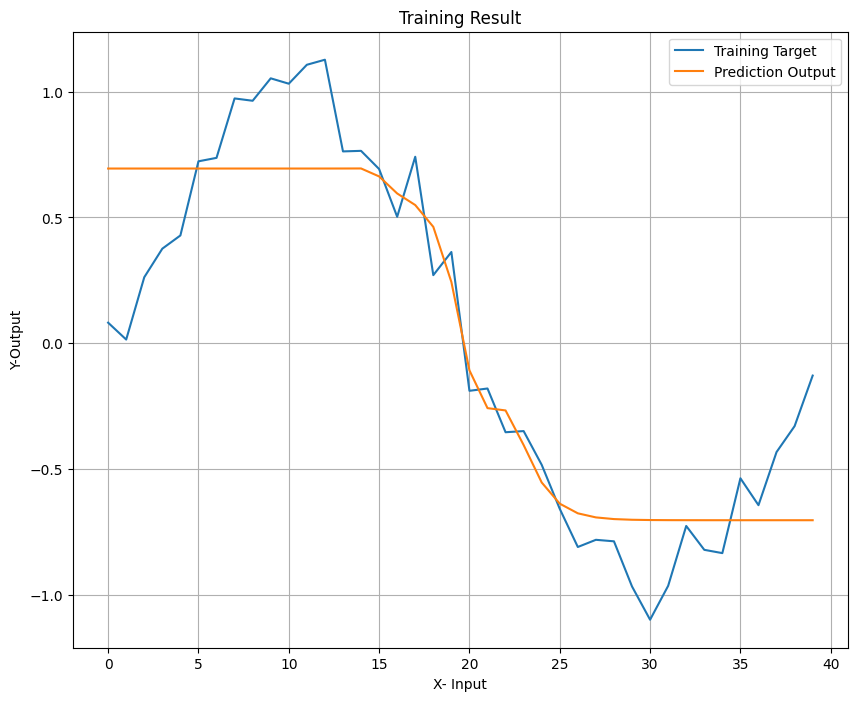

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(X.detach().numpy()[:,0],Y.detach().numpy()[:,0])
plt.plot(X.detach().numpy()[:,0],Ypred.detach().numpy()[:,0])
plt.legend(('Training Target', 'Prediction Output'))
plt.xlabel('X- Input')
plt.ylabel('Y-Output')
plt.title('Training Result')
plt.grid()
Yvalpred=model(Xval) # Make Predictions based on the obtained weights
#print("Y validation set=", Yvalpred.detach().numpy())
loss=loss_fn(Yvalpred[:N,:], Yval[:N,:])
print("Loss on validation set:", loss.detach().numpy())


Observe that the optimization has a harder time to fit the function, despite the 15 times more iterations. But often it is found that deep networks are better for the generalization, which should give the Loss for the validation and test similar values as for training.

The plots the results for the validation set:

weights= OrderedDict([('layer1.0.weight', tensor([[-1.9536],
        [-0.9079]])), ('layer1.0.bias', tensor([26.4035, 17.5593])), ('layer2.0.weight', tensor([[23.5458,  3.9218],
        [-1.3773, -7.7963]])), ('layer2.0.bias', tensor([-0.6769,  0.1543])), ('layer3.0.weight', tensor([[ 9.1493, -9.2857],
        [-2.6308, -2.0050]])), ('layer3.0.bias', tensor([3.2170, 1.8462])), ('layer4.0.weight', tensor([[ 3.1257, -4.6472]])), ('layer4.0.bias', tensor([-0.9755]))])
model.state_dict()['layer2.0.weight']= tensor([[23.5458,  3.9218],
        [-1.3773, -7.7963]])


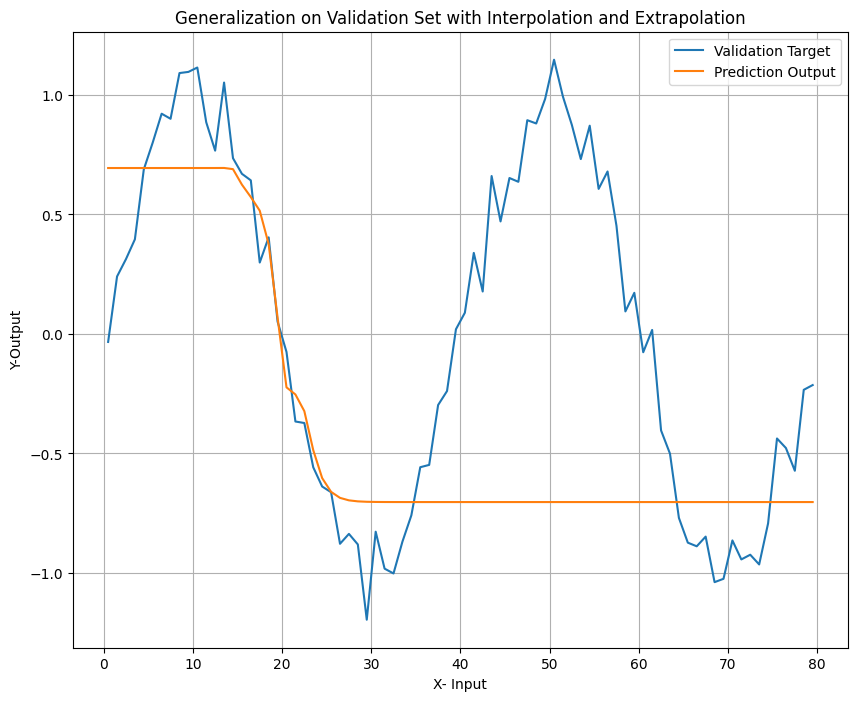

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(Xval.detach().numpy()[:,0],Yval.detach().numpy()[:,0])
plt.plot(Xval.detach().numpy()[:,0],Yvalpred.detach().numpy()[:,0])
plt.xlabel('X- Input')
plt.ylabel('Y-Output')
plt.title('Generalization on Validation Set with Interpolation and Extrapolation')
plt.legend(('Validation Target', 'Prediction Output'))
plt.grid()

weights = model.state_dict()   #read obtained weights
print("weights=", weights)
#Weights of layer 2:
layer2weights=model.state_dict()['layer2.0.weight'].clone() #clone(), otherwise it is just a pointer!
print("model.state_dict()['layer2.0.weight']=", layer2weights)


We see that it does a reasonable interpolation, with a smooth curve fitting.

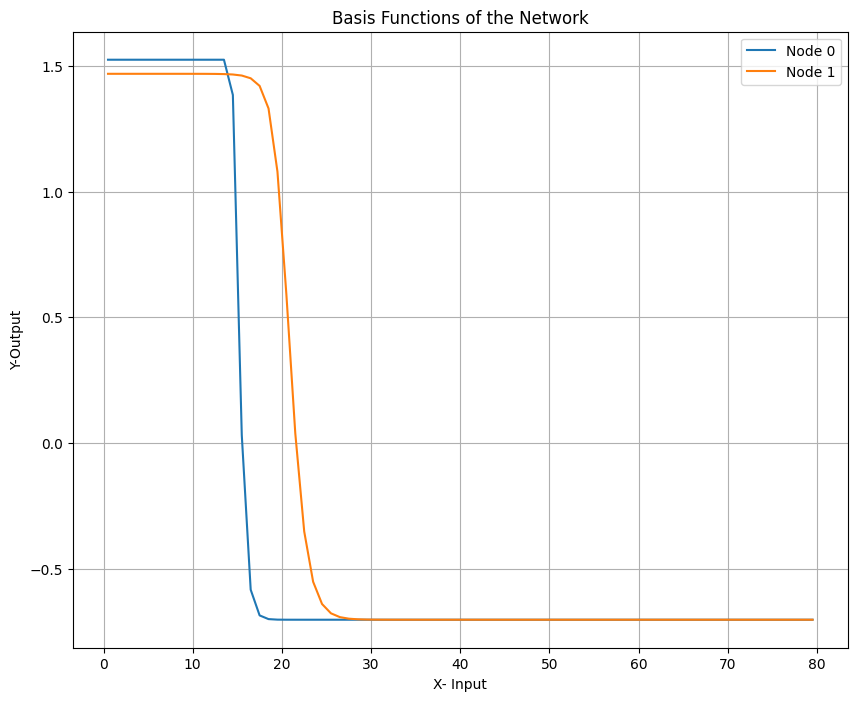

In [ ]:
#The resulting function from the network is the sum of the functions of the N nodes.
#To see the functions of the individual nodes, we can just keep their weight unchanged,
#set the others to zero, and plot the resulting function.
#For that we make mask with zeros for the weights of layer 2, except for one node:

plt.figure(figsize=(10,8))
plt.xlabel('X- Input')
plt.ylabel('Y-Output')
plt.title('Basis Functions of the Network')
for node in range(0,Nodes):
    weightmask=torch.zeros(layer2weights.shape) #mask with all zeros for output layer, except one.
    weightmask[0,node]=1.0 #node "node" unchanged
    #print("weightmask",weightmask)
    #print("layer2weights=",layer2weights)
    #print("layer2weights*weightmask=", layer2weights*weightmask)
    model.state_dict()['layer2.0.weight'].data.copy_(layer2weights*weightmask) #write pytorch structure back to model
    #print("Xval=", Xval)
    Ypred1node=model(Xval) # Make Predictions based on the 1-node weights
    #print("Ypred1node=", Ypred1node)
    #Plot modified 1-node model:
    plt.plot(Xval.detach().numpy()[:,0],Ypred1node.detach().numpy()[:,0])

#plt.legend(('Validation Target', 'Prediction Output', 'Node 0', 'Node 5'))
plt.legend(('Node 0', 'Node 1', 'Node2'))
plt.grid()
#We see the activation function fit with bias and weight
#to different parts of the target function